# Debug Notebook for GitHub Copilot Usage

This notebook demonstrates how to instantiate and invoke methods from your local exporter scripts. You can use it to debug the data extraction and adaptation processes for GitHub Copilot usage data.

In [4]:
# If your project structure is something like:
# PROJECT_ROOT/
#   |-- notebooks/debug_copilot_usage.ipynb
#   |-- src/
#        |-- extractor/
#             |-- github_exporter.py
#             |-- github_copilot_exporter.py
#        |-- common/
#             |-- common.py
#        |-- ...
# make sure to add the project root to sys.path if needed.

import sys
import os
project_root = os.path.abspath(os.path.join('..'))  # Adjust path if needed
if project_root not in sys.path:
    sys.path.append(project_root)

# Now we can import our local modules:


## Prepare a Configuration Dictionary
Below is a sample configuration dictionary. Adjust the values according to your project’s needs or how you manage configs (e.g., from a .ini or .env file).

In [5]:

from src.extractor.github_copilot_exporter import GithubCopilotExporter
from src.transformer.copilot_transformer import CopilotTransformer
from src.loader.csv_loader import CsvLoader

import pandas as pd

pd.options.mode.chained_assignment = None

config = {
    "GITHUB": {
        "github_url": "https://api.github.com",
        "github_org": "gologic-partner",     # Replace with your organization
        "github_token": ""
    }   
}

# Instantiate the Exporter
copilot_exporter = GithubCopilotExporter()
copilot_exporter.initialize_data(config)

copilot_transformer = CopilotTransformer()
copilot_transformer.initialize_data(config)

csv_loader = CsvLoader()
csv_loader.initialize_data({
    "CSV": {
        "csv_filename_prefix": "copilot"  # This will create files like copilot_metrics_chat_global.csv
    }
})

## Call the Copilot Usage Endpoint
We’ll do a simple request to GitHub’s Copilot usage endpoint. Adjust the query parameters (e.g., since, until) as needed.

For reference, see: [Copilot Usage Docs](https://docs.github.com/en/rest/copilot/copilot-usage?apiVersion=2022-11-28).

In [6]:
# Cell 2 - Code
# First get the teams
teams = copilot_exporter.extract_teams()
print("\nTeams found:")
for team in teams:
    print(f"- {team['name']} (slug: {team['slug']})")


Teams found:
- Équipe développement 1 (slug: equipe-developpement-1)
- Équipe GitHub (slug: equipe-github)
- go-squad (slug: go-squad)


c:\Users\SébastienBernard\Documents\GitHub\devops-metrics\.venv\Lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.github.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [7]:
# Cell 3 - Code
# Get metrics for each team
metrics_per_team = copilot_exporter.extract_metrics_per_team(teams)
metrics_per_team


c:\Users\SébastienBernard\Documents\GitHub\devops-metrics\.venv\Lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.github.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\SébastienBernard\Documents\GitHub\devops-metrics\.venv\Lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.github.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


No Copilot metrics found for team go-squad


c:\Users\SébastienBernard\Documents\GitHub\devops-metrics\.venv\Lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.github.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


{'equipe-developpement-1': [{'date': '2025-01-28',
   'copilot_ide_chat': {'editors': [{'name': 'vscode',
      'models': [{'name': 'default',
        'total_chats': 20,
        'is_custom_model': False,
        'total_engaged_users': 1,
        'total_chat_copy_events': 0,
        'total_chat_insertion_events': 0}],
      'total_engaged_users': 1},
     {'name': 'JetBrains',
      'models': [{'name': 'default',
        'total_chats': 16,
        'is_custom_model': False,
        'total_engaged_users': 3,
        'total_chat_copy_events': 3,
        'total_chat_insertion_events': 3}],
      'total_engaged_users': 3}],
    'total_engaged_users': 3},
   'total_active_users': 5,
   'copilot_dotcom_chat': {'total_engaged_users': 0},
   'total_engaged_users': 5,
   'copilot_dotcom_pull_requests': {'total_engaged_users': 0},
   'copilot_ide_code_completions': {'editors': [{'name': 'JetBrains',
      'models': [{'name': 'default',
        'languages': [{'name': 'csharp',
          'total_enga

In [8]:
adapted_metrics_chat_per_team = copilot_exporter.adapt_metrics_chat_team(metrics_per_team)
adapted_metrics_chat_per_team

,team,date,editor_name,model_name,total_engaged_users,total_chat,total_chat_insertion_events,total_chat_copy_events
0,equipe-developpement-1,2025-01-28,vscode,default,1,20,0,0
1,equipe-developpement-1,2025-01-28,JetBrains,default,3,16,3,3
2,equipe-developpement-1,2025-01-29,JetBrains,default,3,18,5,5
3,equipe-developpement-1,2025-01-30,JetBrains,default,3,36,8,8
4,equipe-developpement-1,2025-01-30,vscode,default,1,11,0,0
5,equipe-developpement-1,2025-01-31,JetBrains,default,3,16,1,1
6,equipe-developpement-1,2025-01-31,vscode,default,1,6,0,0
7,equipe-github,2025-01-28,JetBrains,default,3,16,6,15
8,equipe-github,2025-01-28,vscode,default,2,33,0,6
9,equipe-github,2025-01-29,JetBrains,default,3,16,5,7


In [9]:
adapted_metrics_completition_per_team = copilot_exporter.adapt_metrics_completions_team(metrics_per_team)
adapted_metrics_completition_per_team

,team,date,editor_name,model_name,language,total_code_lines_suggested,total_code_lines_accepted,total_engaged_users
0,equipe-developpement-1,2025-01-28,JetBrains,default,csharp,74,10,2
1,equipe-developpement-1,2025-01-28,JetBrains,default,powershell,355,78,2
2,equipe-developpement-1,2025-01-28,JetBrains,default,java,18,6,2
3,equipe-developpement-1,2025-01-28,Neovim,default,unknown,83,1,1
4,equipe-developpement-1,2025-01-29,JetBrains,default,java,111,16,3
5,equipe-developpement-1,2025-01-29,JetBrains,default,csharp,116,17,3
6,equipe-developpement-1,2025-01-29,Neovim,default,unknown,308,5,1
7,equipe-developpement-1,2025-01-29,Neovim,default,shellscript,88,5,1
8,equipe-developpement-1,2025-01-30,JetBrains,default,json,10,1,3
9,equipe-developpement-1,2025-01-30,JetBrains,default,csharp,538,93,3


In [10]:
global_metrics = copilot_exporter.extract_metrics_global()
global_metrics

c:\Users\SébastienBernard\Documents\GitHub\devops-metrics\.venv\Lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.github.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


[{'date': '2025-01-07',
  'copilot_ide_chat': {'editors': [{'name': 'JetBrains',
     'models': [{'name': 'default',
       'total_chats': 81,
       'is_custom_model': False,
       'total_engaged_users': 5,
       'total_chat_copy_events': 11,
       'total_chat_insertion_events': 11}],
     'total_engaged_users': 5},
    {'name': 'vscode',
     'models': [{'name': 'default',
       'total_chats': 29,
       'is_custom_model': False,
       'total_engaged_users': 4,
       'total_chat_copy_events': 0,
       'total_chat_insertion_events': 0}],
     'total_engaged_users': 4}],
   'total_engaged_users': 9},
  'total_active_users': 11,
  'copilot_dotcom_chat': {'total_engaged_users': 0},
  'total_engaged_users': 10,
  'copilot_dotcom_pull_requests': {'total_engaged_users': 0},
  'copilot_ide_code_completions': {'editors': [{'name': 'JetBrains',
     'models': [{'name': 'default',
       'languages': [{'name': 'csharp',
         'total_engaged_users': 3,
         'total_code_acceptances'

In [11]:
# Create a DataFrame from the global metrics data and normalize nested JSON
import pandas as pd
import json
from pandas.io.json import json_normalize

# First flatten the nested copilot_ide_chat structure
flattened_metrics = []
for metric in global_metrics:
    # Get base fields
    flat_metric = {
        'date': metric['date']
    }
    
    # Extract editor metrics
    for editor in metric['copilot_ide_chat']['editors']:
        for model in editor['models']:
            # Add editor and model info
            record = flat_metric.copy()
            record.update({
                'editor_name': editor['name'],
                'model_name': model['name'],
                'total_engaged_users': model.get('total_engaged_users', 0),
                'total_chats': model.get('total_chats', 0)
            })
            
            # Add language-specific metrics if present
            if 'languages' in model:
                for lang in model['languages']:
                    lang_record = record.copy()
                    lang_record.update({
                        'language': lang['name'],
                        'language_engaged_users': lang.get('total_engaged_users', 0)
                    })
                    flattened_metrics.append(lang_record)
            else:
                flattened_metrics.append(record)

# Create normalized DataFrame
df_global_metrics = pd.DataFrame(flattened_metrics)
display(df_global_metrics)


,date,editor_name,model_name,total_engaged_users,total_chats
0,2025-01-07,JetBrains,default,5,81
1,2025-01-07,vscode,default,4,29
2,2025-01-08,JetBrains,default,5,76
3,2025-01-08,vscode,default,3,21
4,2025-01-09,JetBrains,default,5,48
5,2025-01-09,vscode,default,3,52
6,2025-01-10,JetBrains,default,3,28
7,2025-01-10,vscode,default,3,45
8,2025-01-13,JetBrains,default,2,22
9,2025-01-13,vscode,default,1,9


In [12]:
adapted_global_metrics = copilot_exporter.adapt_metrics_chat_global(global_metrics)
adapted_global_metrics


,team,date,editor_name,model_name,total_engaged_users,total_chat,total_chat_insertion_events,total_chat_copy_events
0,None,2025-01-07,JetBrains,default,5,81,11,11
1,None,2025-01-07,vscode,default,4,29,0,0
2,None,2025-01-08,JetBrains,default,5,76,13,18
3,None,2025-01-08,vscode,default,3,21,0,4
4,None,2025-01-09,JetBrains,default,5,48,11,8
5,None,2025-01-09,vscode,default,3,52,0,5
6,None,2025-01-10,JetBrains,default,3,28,5,7
7,None,2025-01-10,vscode,default,3,45,0,7
8,None,2025-01-13,JetBrains,default,2,22,4,2
9,None,2025-01-13,vscode,default,1,9,0,0


In [13]:
adapted_metrics_completion_global = copilot_exporter.adapt_metrics_completions_global(global_metrics)
adapted_metrics_completion_global


,team,date,editor_name,model_name,language,total_code_lines_suggested,total_code_lines_accepted,total_engaged_users
0,None,2025-01-07,JetBrains,default,csharp,757,182,6
1,None,2025-01-07,JetBrains,default,java,239,48,6
2,None,2025-01-07,JetBrains,default,json,9,1,6
3,None,2025-01-07,JetBrains,default,ini,14,1,6
4,None,2025-01-07,JetBrains,default,xml,1,1,6
...,...,...,...,...,...,...,...,...
195,None,2025-01-31,vscode,default,unknown,3,1,2
196,None,2025-01-31,vscode,default,yaml,16,8,2
197,None,2025-01-31,vscode,default,shellscript,90,20,2
198,None,2025-01-31,vscode,default,terraform,302,32,2


In [14]:
transformed_metrics_chat = copilot_transformer.transform_chat_metrics_team(adapted_metrics_chat_per_team)
print("Transformed Chat Metrics per Team:")
display(transformed_metrics_chat)

Transformed Chat Metrics per Team:


,team,date,total_chat,total_engaged_users,total_chat_copy_events,total_chat_insertion_events,chat_per_user,chat_acceptance_rate
0,equipe-developpement-1,2025-01-28,36,4,3,3,9.000000,0.166667
1,equipe-developpement-1,2025-01-29,18,3,5,5,6.000000,0.555556
2,equipe-developpement-1,2025-01-30,47,4,8,8,11.750000,0.340426
3,equipe-developpement-1,2025-01-31,22,4,1,1,5.500000,0.090909
4,equipe-github,2025-01-28,49,5,21,6,9.800000,0.551020
5,equipe-github,2025-01-29,19,4,7,5,4.750000,0.631579
6,equipe-github,2025-01-30,29,3,11,10,9.666667,0.724138
7,equipe-github,2025-01-31,43,3,6,3,14.333333,0.209302


In [15]:
transformed_completion_metrics = copilot_transformer.transform_completion_metrics_team(adapted_metrics_completition_per_team)
print("Transformed Completion Metrics per Team:")
display(transformed_completion_metrics)


Transformed Completion Metrics per Team:


,team,date,language,total_code_lines_accepted,total_code_lines_suggested,completion_acceptance_rate
0,equipe-developpement-1,2025-01-28,csharp,10,74,0.135135
1,equipe-developpement-1,2025-01-28,java,6,18,0.333333
2,equipe-developpement-1,2025-01-28,powershell,78,355,0.219718
3,equipe-developpement-1,2025-01-28,unknown,1,83,0.012048
4,equipe-developpement-1,2025-01-29,csharp,17,116,0.146552
5,equipe-developpement-1,2025-01-29,java,16,111,0.144144
6,equipe-developpement-1,2025-01-29,shellscript,5,88,0.056818
7,equipe-developpement-1,2025-01-29,unknown,5,308,0.016234
8,equipe-developpement-1,2025-01-30,csharp,93,538,0.172862
9,equipe-developpement-1,2025-01-30,html,0,2,0.000000


In [16]:
transformed_global_chat = copilot_transformer.transform_chat_metrics_global(adapted_global_metrics)
print("Transformed Global Chat Metrics:")
display(transformed_global_chat)

Transformed Global Chat Metrics:


,date,total_chat,total_engaged_users,total_chat_copy_events,total_chat_insertion_events,chat_per_user,chat_acceptance_rate
0,2025-01-07,110,9,11,11,12.222222,0.200000
1,2025-01-08,97,8,22,13,12.125000,0.360825
2,2025-01-09,100,8,13,11,12.500000,0.240000
3,2025-01-10,73,6,14,5,12.166667,0.260274
4,2025-01-13,31,3,2,4,10.333333,0.193548
5,2025-01-14,267,7,19,14,38.142857,0.123596
6,2025-01-15,317,10,30,5,31.700000,0.110410
7,2025-01-16,95,7,12,19,13.571429,0.326316
8,2025-01-17,125,7,23,3,17.857143,0.208000
9,2025-01-18,7,2,1,0,3.500000,0.142857


In [17]:
transformed_global_completion = copilot_transformer.transform_completion_metrics_global(adapted_metrics_completion_global)
print("Transformed Global Completion Metrics:")
display(transformed_global_completion)

Transformed Global Completion Metrics:


,date,language,total_code_lines_accepted,total_code_lines_suggested,completion_acceptance_rate
0,2025-01-07,csharp,182,757,0.240423
1,2025-01-07,dockerfile,1,16,0.062500
2,2025-01-07,go,7,26,0.269231
3,2025-01-07,ini,1,18,0.055556
4,2025-01-07,java,48,239,0.200837
...,...,...,...,...,...
171,2025-01-31,sql,6,49,0.122449
172,2025-01-31,terraform,32,302,0.105960
173,2025-01-31,unknown,5,116,0.043103
174,2025-01-31,xml,0,1,0.000000


In [18]:
transformed_data = {
    "metrics_chat_global": transformed_global_chat,
    "metrics_chat_team": transformed_metrics_chat,
    "metrics_completion_global": transformed_global_completion,
    "metrics_completion_team": transformed_completion_metrics
}

csv_loader.load_data(transformed_data)

CSV file copilot_metrics_chat_global.csv created
CSV file copilot_metrics_chat_team.csv created
CSV file copilot_metrics_completion_global.csv created
CSV file copilot_metrics_completion_team.csv created


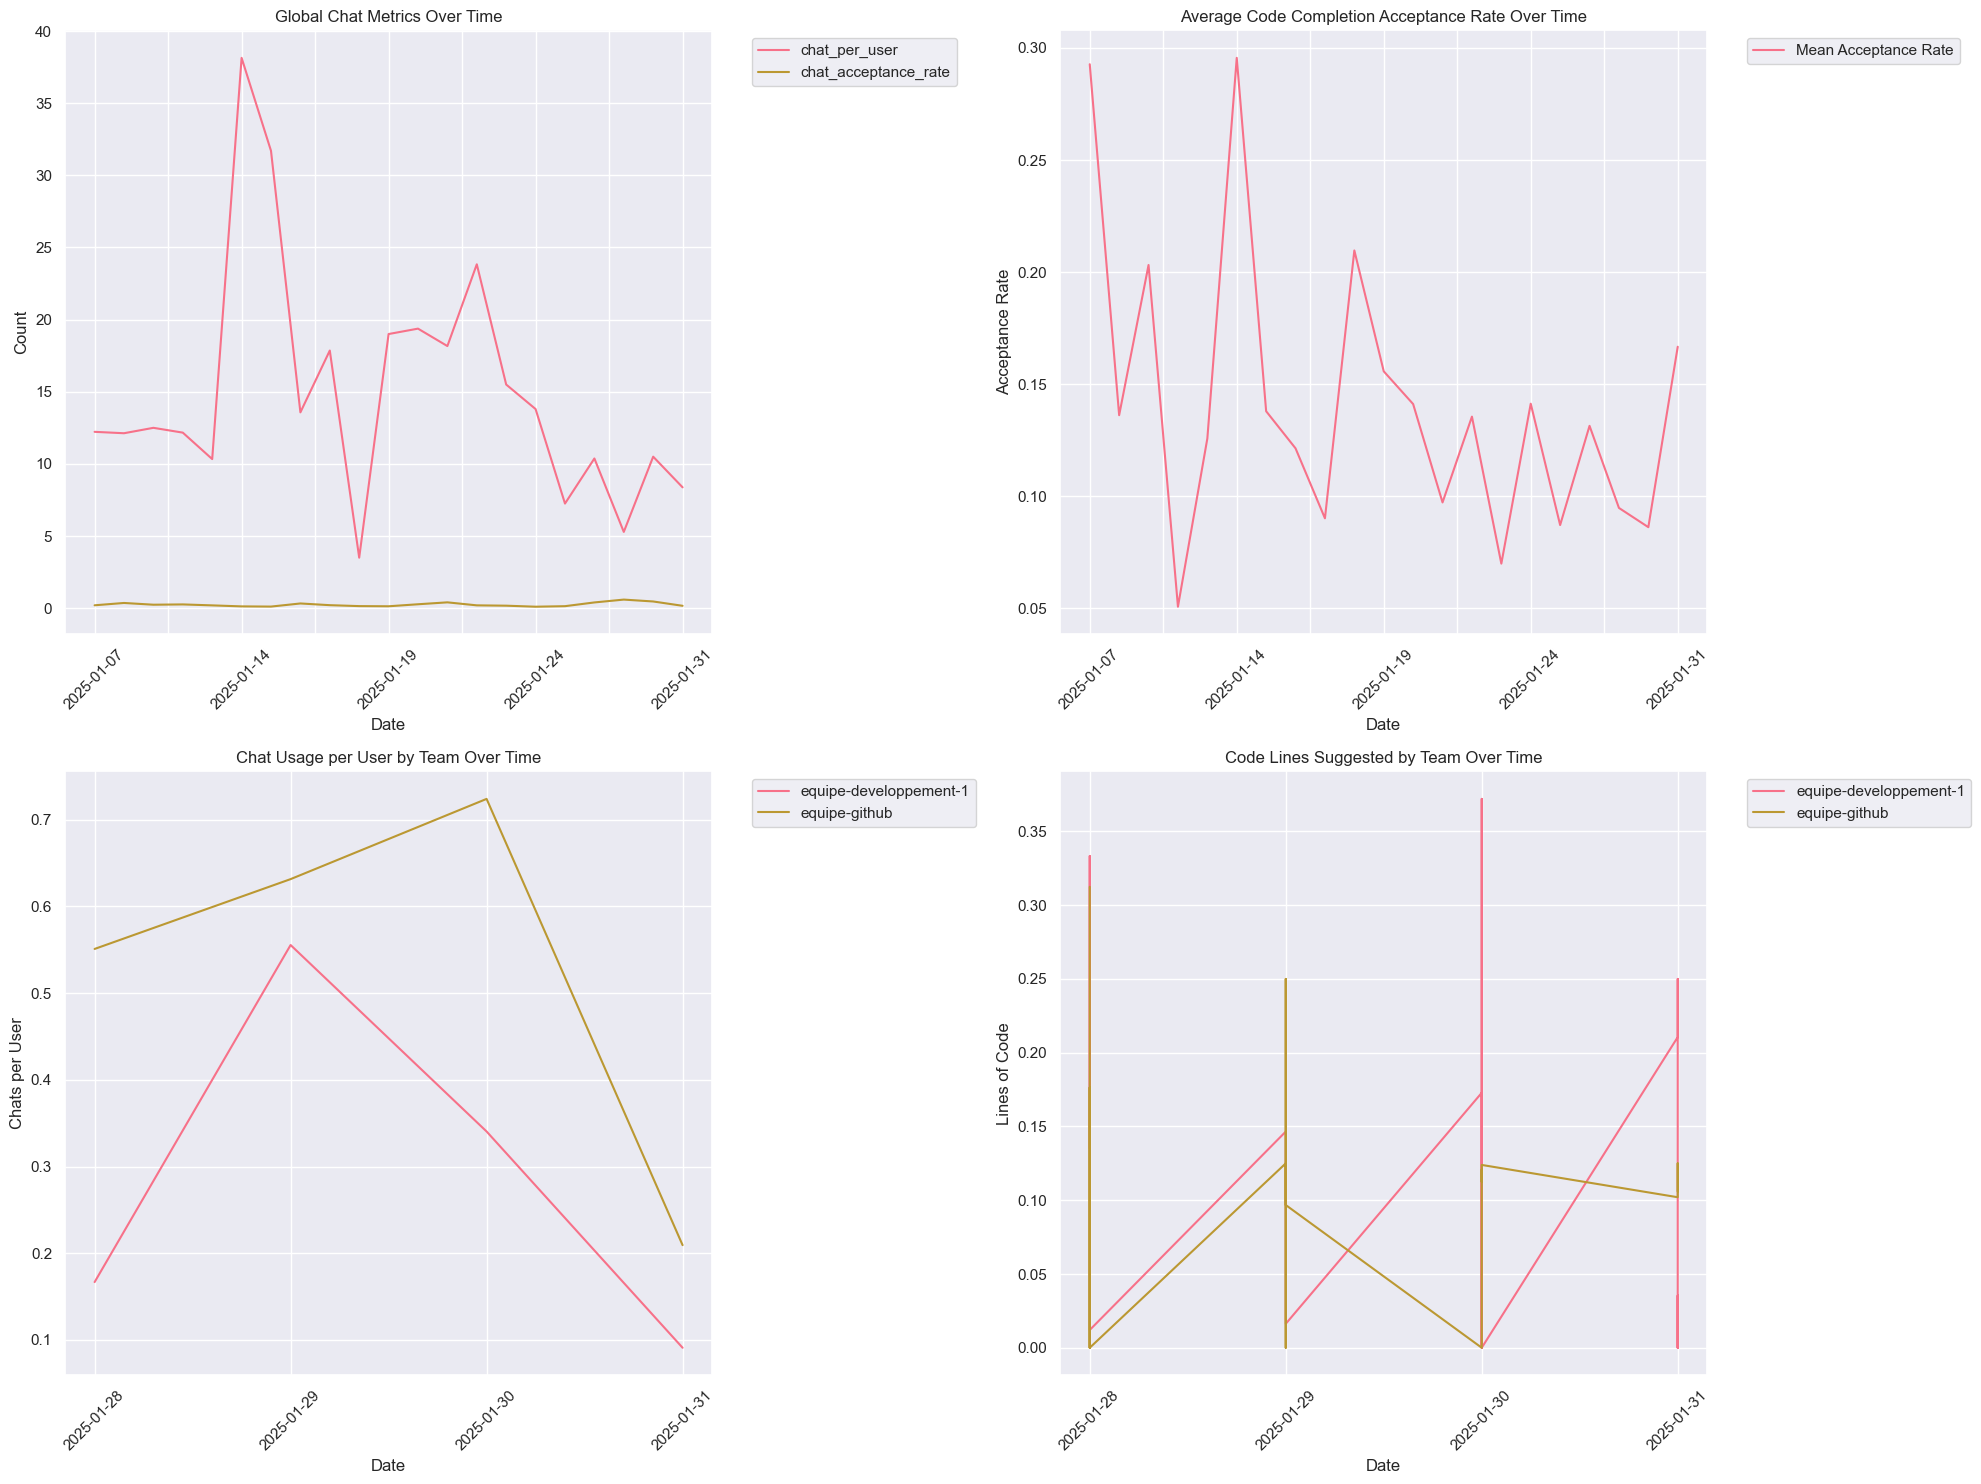

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the style
sns.set_theme()
sns.set_palette("husl")

# Create a figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Plot 1: Global Chat Metrics Over Time
transformed_global_chat.plot(x='date', y=['chat_per_user', 'chat_acceptance_rate'], ax=ax1)
ax1.set_title('Global Chat Metrics Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Global Completion Metrics Over Time
mean_acceptance = transformed_global_completion.groupby('date')['completion_acceptance_rate'].mean()
mean_acceptance.plot(ax=ax2)
ax2.set_title('Average Code Completion Acceptance Rate Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Acceptance Rate')
ax2.legend(['Mean Acceptance Rate'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Chat Metrics by Team Over Time
lines = []
for team in transformed_metrics_chat['team'].unique():
    team_data = transformed_metrics_chat[transformed_metrics_chat['team'] == team]
    line, = ax3.plot(team_data['date'], team_data['chat_acceptance_rate'], label=team)
    lines.append(line)
ax3.set_title('Chat Usage per User by Team Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Chats per User')
ax3.legend(handles=lines, bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Code Completion by Team Over Time
lines = []
for team in transformed_completion_metrics['team'].unique():
    team_data = transformed_completion_metrics[transformed_completion_metrics['team'] == team]
    line, = ax4.plot(team_data['date'], team_data['completion_acceptance_rate'], label=team)
    lines.append(line)
ax4.set_title('Code Lines Suggested by Team Over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('Lines of Code')
ax4.legend(handles=lines, bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Conclusion
You can now inspect these DataFrames, observe schema changes, and debug any issues with your transformation logic or with the GitHub API data itself. Use additional cells as needed to explore data, handle errors, etc.